In [ ]:
!pip install torchtext==0.17 torch datasets

In [2]:
!git clone https://github.com/MiuLab/SlotGated-SLU.git

Cloning into 'SlotGated-SLU'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 51 (delta 4), reused 2 (delta 2), pack-reused 44 (from 1)
Receiving objects: 100% (51/51), 426.21 KiB | 6.18 MiB/s, done.
Resolving deltas: 100% (14/14), done.


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from datasets import Dataset, DatasetDict

import numpy as np
from tqdm.notebook import tqdm
from collections import Counter

import sys
import time
import random

In [4]:
import nltk
from nltk import word_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [5]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [6]:
import os

def read_dataset(path):
    with open(os.path.join(path, 'seq.in')) as f_words, \
        open(os.path.join(path, 'seq.out')) as f_tags, \
        open(os.path.join(path, 'label')) as f_intents:

        texts, slot_labels, intent_labels = [], [], []
        for words, tags, intent in zip(f_words, f_tags, f_intents):
            texts.append(words.strip().split())
            slot_labels.append(tags.strip().split())
            intent_labels.append(intent.strip())
        return Dataset.from_dict({"words": texts,
                                  "tags": slot_labels,
                                  "intent": intent_labels})

In [7]:
datasets = DatasetDict()
for split_name in ["train", "valid", "test"]:
    datasets[split_name] = read_dataset(f"/content/SlotGated-SLU/data/snips/{split_name}")

In [8]:
datasets["train"][0]

{'words': ['listen',
  'to',
  'westbam',
  'alumb',
  'allergic',
  'on',
  'google',
  'music'],
 'tags': ['O', 'O', 'B-artist', 'O', 'B-album', 'O', 'B-service', 'I-service'],
 'intent': 'PlayMusic'}

In [9]:
intent_to_example = {example["intent"]: example for example in datasets["train"]}
for example in intent_to_example.values():
    print('Intent:\t', example["intent"])
    print('Words:\t', '\t'.join(example["words"]))
    print('Tags:\t', '\t'.join(example["tags"]))
    print()

Intent:	 PlayMusic
Words:	 play	funky	heavy	bluesy
Tags:	 O	B-playlist	I-playlist	I-playlist

Intent:	 AddToPlaylist
Words:	 add	gabrial	mcnair	to	my	love	in	paris	list
Tags:	 O	B-artist	I-artist	O	B-playlist_owner	B-playlist	I-playlist	I-playlist	O

Intent:	 RateBook
Words:	 rate	richard	carvel	4	out	of	6
Tags:	 O	B-object_name	I-object_name	B-rating_value	O	O	B-best_rating

Intent:	 SearchScreeningEvent
Words:	 can	i	get	the	movie	schedule	for	loews	cineplex	entertainment
Tags:	 O	O	O	O	B-object_type	I-object_type	O	B-location_name	I-location_name	I-location_name

Intent:	 BookRestaurant
Words:	 i	want	to	eat	choucroute	at	a	brasserie	for	8
Tags:	 O	O	O	O	B-served_dish	O	O	B-restaurant_type	O	B-party_size_number

Intent:	 GetWeather
Words:	 tell	me	when	it	ll	be	chillier	in	cavalero	corner	id
Tags:	 O	O	O	O	O	O	B-condition_temperature	O	B-city	I-city	B-state

Intent:	 SearchCreativeWork
Words:	 go	to	the	photograph	the	inflated	tear
Tags:	 O	O	O	B-object_type	B-object_name	I-object_n

In [10]:
tags_counter = Counter()

for tags in datasets['train']['tags']:
    tags_counter.update(tags)

In [12]:
len(tags_counter)

72

In [11]:
n_train_tags = sum(tags_counter.values())

for tag, tag_count in tags_counter.most_common():
    print(f'{tag}\t{tag_count / n_train_tags * 100: .2f}%')

O	 48.67%
I-object_name	 6.36%
I-playlist	 2.75%
B-object_type	 2.57%
B-object_name	 2.37%
I-timeRange	 2.35%
B-playlist	 1.67%
B-timeRange	 1.60%
B-rating_value	 1.59%
I-movie_name	 1.59%
B-artist	 1.53%
I-artist	 1.50%
B-music_item	 1.34%
B-city	 1.11%
B-restaurant_type	 1.10%
I-entity_name	 1.00%
B-spatial_relation	 0.98%
B-rating_unit	 0.92%
B-playlist_owner	 0.89%
B-best_rating	 0.86%
B-party_size_number	 0.83%
I-object_type	 0.82%
B-state	 0.81%
B-object_select	 0.80%
I-party_size_description	 0.77%
I-spatial_relation	 0.71%
I-geographic_poi	 0.71%
B-country	 0.69%
B-movie_name	 0.65%
B-service	 0.63%
I-location_name	 0.60%
B-movie_type	 0.57%
B-year	 0.52%
B-location_name	 0.48%
I-restaurant_name	 0.48%
B-entity_name	 0.48%
B-sort	 0.44%
B-condition_temperature	 0.38%
I-city	 0.38%
B-object_location_type	 0.38%
B-condition_description	 0.36%
I-track	 0.35%
I-album	 0.31%
I-country	 0.28%
B-restaurant_name	 0.28%
B-party_size_description	 0.26%
B-object_part_of_series_type	 0.25%

In [13]:
TEXT_LOWER = True

In [14]:
MIN_FREQ = 3

tokens_vocab = torchtext.vocab.build_vocab_from_iterator(datasets['train']['words'], min_freq=MIN_FREQ,
                                                         specials=['<unk>', '<pad>'])

tags_vocab = torchtext.vocab.build_vocab_from_iterator(datasets['train']['tags'], specials=['<pad>'])

In [15]:
len(tokens_vocab), len(tags_vocab)

(2834, 73)

In [16]:
tokens_vocab['food']

124

In [17]:
tags_vocab['B-playlist']

7

In [18]:
# tokens_vocab['blablabla']

In [19]:
tokens_vocab.set_default_index(tokens_vocab['<unk>'])

In [20]:
tokens_vocab['blablabla'], tokens_vocab['<unk>']

(0, 0)

In [23]:
idx_to_tag = tags_vocab.vocab.get_itos()
# idx_to_tag

In [24]:
tag_to_idx = tags_vocab.vocab.get_stoi()
# tag_to_idx

Но удобнее пользоваться готовыми функциями, для преобразования нескольких токенов (тегов) в индексы и обратно.

In [26]:
datasets['train']['words'][42]

['let', 'me', 'see', 'the', 'movie', 'schedule', 'for', 'seed', 'of', 'chucky']

In [27]:
datasets['train']['tags'][42]

['O',
 'O',
 'O',
 'O',
 'O',
 'B-object_type',
 'O',
 'B-movie_name',
 'I-movie_name',
 'I-movie_name']

In [28]:
token_idxs_example = tokens_vocab.forward(datasets['train']['words'][42])
tag_idxs_example = tags_vocab.forward(datasets['train']['tags'][42])

In [29]:
print(token_idxs_example)

[331, 18, 105, 2, 22, 56, 6, 2019, 7, 0]


In [30]:
print(tag_idxs_example)

[1, 1, 1, 1, 1, 4, 1, 29, 10, 10]


In [31]:
print(tokens_vocab.lookup_tokens(token_idxs_example))
print(datasets['train']['words'][42])

['let', 'me', 'see', 'the', 'movie', 'schedule', 'for', 'seed', 'of', '<unk>']
['let', 'me', 'see', 'the', 'movie', 'schedule', 'for', 'seed', 'of', 'chucky']


In [32]:
print(tags_vocab.lookup_tokens(tag_idxs_example))
print(datasets['train']['tags'][42])

['O', 'O', 'O', 'O', 'O', 'B-object_type', 'O', 'B-movie_name', 'I-movie_name', 'I-movie_name']
['O', 'O', 'O', 'O', 'O', 'B-object_type', 'O', 'B-movie_name', 'I-movie_name', 'I-movie_name']


Теперь, наконец, переведем все наши данные в числовой формат.

In [33]:
def numericalize_data(example):
    token_idxs = tokens_vocab.forward(example['words'])
    tag_idxs = tags_vocab.forward(example['tags'])
    return {'token_idxs': token_idxs, 'tag_idxs': tag_idxs}

Применяем функцию `numericalize_data` ко всем данным, удаляем ненужные колонки и переводим данные в тип `torch.Tensor`.

In [34]:
datasets

DatasetDict({
    train: Dataset({
        features: ['words', 'tags', 'intent'],
        num_rows: 13084
    })
    valid: Dataset({
        features: ['words', 'tags', 'intent'],
        num_rows: 700
    })
    test: Dataset({
        features: ['words', 'tags', 'intent'],
        num_rows: 700
    })
})

In [35]:
transformed_data = datasets.map(numericalize_data, remove_columns=['words', 'tags', 'intent']).with_format(type='torch')

Map:   0%|          | 0/13084 [00:00<?, ? examples/s]

Map:   0%|          | 0/700 [00:00<?, ? examples/s]

Map:   0%|          | 0/700 [00:00<?, ? examples/s]

In [36]:
transformed_data

DatasetDict({
    train: Dataset({
        features: ['token_idxs', 'tag_idxs'],
        num_rows: 13084
    })
    valid: Dataset({
        features: ['token_idxs', 'tag_idxs'],
        num_rows: 700
    })
    test: Dataset({
        features: ['token_idxs', 'tag_idxs'],
        num_rows: 700
    })
})

In [37]:
transformed_data['train']['token_idxs'][0]

tensor([187,   5,   0,   0,   0,  19, 201,  36])

In [38]:
transformed_data['train']['tag_idxs'][0]

tensor([ 1,  1, 11,  1, 56,  1, 30, 58])

Последний этап предобработки данных -- это создание итераторов, которые будут перемешивать данные и делить их на батчи. За это отвечают объекты класса `DataLoader`. При создании итераторов будем передавать функцию `collate_batch`, которая принимает на вход фрагмент датасета и строит два списка: список токенов (точнее их индексов) и список тегов.

В то время как предложения обычно имеют разную длину, входные и выходные последовательности  представлены в виде трехмерного тензора. Поэтому все короткие предложения в батче приводятся к длине самого длинного предложения путем добавления токена `<pad>` (точнее его индекса).

In [39]:
def collate_batch(batch):
    batch_tokens = [example['token_idxs'] for example in batch]
    batch_tags = [example['tag_idxs'] for example in batch]
    batch_tokens = nn.utils.rnn.pad_sequence(batch_tokens, padding_value=tokens_vocab['<pad>'], batch_first=True)
    batch_tags = nn.utils.rnn.pad_sequence(batch_tags, padding_value=tags_vocab['<pad>'], batch_first=True)
    batch = {'token_idxs': batch_tokens,
             'tag_idxs': batch_tags}
    return batch

In [40]:
BATCH_SIZE = 32

train_dataloader = torch.utils.data.DataLoader(transformed_data['train'],
                                               batch_size=BATCH_SIZE,
                                               collate_fn=collate_batch,
                                               shuffle=True)

validation_dataloader = torch.utils.data.DataLoader(transformed_data['valid'],
                                                    batch_size=BATCH_SIZE,
                                                    collate_fn=collate_batch)

test_dataloader = torch.utils.data.DataLoader(transformed_data['test'],
                                              batch_size=BATCH_SIZE,
                                              collate_fn=collate_batch)

Посмотрим на пример батча:

In [41]:
for batch in train_dataloader:
    break

In [42]:
batch

{'token_idxs': tensor([[  15,   22,   84,    4,  815,   62,    1,    1,    1,    1,    1,    1,
             1,    1,    1,    1],
         [   8,   61,   44,    5,  244, 1381,  651,    9,    2,  151,    4, 2305,
             1,    1,    1,    1],
         [  11,   34,  115,    5,   28,  586,    4, 1255,    0,  724,  241,    1,
             1,    1,    1,    1],
         [  13, 1306,   19,    5,   16,  559,  255,   27, 1703,   17,    1,    1,
             1,    1,    1,    1],
         [  70,   38,    8,  457,    3,  999,    7,    2,  139,   54, 1398, 1241,
            20,  632,    1,    1],
         [  13,    3,   65,    5,   16,  627,  190,   17,    1,    1,    1,    1,
             1,    1,    1,    1],
         [  13,    2,    0,    0,   46,    5,   16, 2677,  200,  309,   17,    1,
             1,    1,    1,    1],
         [  13,  133,    5, 2707, 1697,  406,   17,    1,    1,    1,    1,    1,
             1,    1,    1,    1],
         [   8,   35,    2,  100,   22,   63,   59

Или так:

In [43]:
next(iter(train_dataloader))

{'token_idxs': tensor([[   8,   61,   44,    5,  105,    2,   22,    2,    0,    1,    1,    1,
             1,    1],
         [  14,   11,    2,   97,   29,  346,    7,    0,   25, 2700,    0,    1,
             1,    1],
         [   8,   61,   44,    5,  105,    2,  148,    6,  330,   25,  955,    1,
             1,    1],
         [  15,   85,   59,   22,   84,   49,   57,  145,    1,    1,    1,    1,
             1,    1],
         [  26,    4,    0,    1,    1,    1,    1,    1,    1,    1,    1,    1,
             1,    1],
         [  11, 1994,    0,   43,    1,    1,    1,    1,    1,    1,    1,    1,
             1,    1],
         [  20,   12, 2431,  806,  208,    8,   61,   24,   34,   75,   31,    7,
            21,   40],
         [  12,    3,  106,    4,  543,    4,    2,  175,  103,  200,   18,    1,
             1,    1],
         [  11,   34,  115,    5,   28,  219,    4,    0,    9,   69,   94,    1,
             1,    1],
         [  12,    3,  106,    6,  136,  

## Строим модель

![](assets/pos-bidirectional-lstm.png?raw=1)

Модель получает на вход последовательность индексов токенов $X = \{x_1, x_2,...,x_T\}$, и проводит их через слой эмбеддингов $e$. Таким обазом получаем набор эмбеддингов для каждого слова: $e(X) = \{e(x_1), e(x_2), ..., e(x_T)\}$.

Эти эмбеддинги обрабатываются по одному в один момент времени: по прямой и обратной LSTM. Прямая LSTM обрабатывает последовательность слева направо, а обратная -- справо налево. То есть первый токен прямой LSTM -- $x_1$, первый токен обратной -- $x_T$.

Также LSTM получает а вход скрытое состояние $h$ и состояние ячейки $c$, полученные после обработки предыдущего слова.

$$h^{\rightarrow}_t = \text{LSTM}^{\rightarrow}(e(x^{\rightarrow}_t), h^{\rightarrow}_{t-1}, c^{\rightarrow}_{t-1})$$
$$h^{\leftarrow}_t=\text{LSTM}^{\leftarrow}(e(x^{\leftarrow}_t), h^{\leftarrow}_{t-1}, c^{\leftarrow}_{t-1})$$

После того, как последовательность была полностью обработана, скрытое состояния передаются в следующий слой LSTM.

Начальные значения $h_0$ и $c_0$ инициализируются тензором из нулей.


Все скрытыте состояния после прямого и обратного прохода на последнем слое LSTM конкатенируются: $H = \{h_1, h_2, ... h_T\}$, где $h_1 = [h^{\rightarrow}_1;h^{\leftarrow}_T]$, $h_2 = [h^{\rightarrow}_2;h^{\leftarrow}_{T-1}]$ и т.д. и подаются на вход линейному слою $f$, который используется для предсказания того, какой тег соответствует токену: $\hat{y}_t = f(h_t)$.

В процессе тренировки модели мы будем сравнивать наши предсказанные теги $\hat{Y}$ с тегами из датасета $Y$, вычислять значение функции ошибки, вычислять градиенты и обновлять наши параметры.

`nn.Embedding` слой эмбеддингов, input_dim которого должен быть равен размеру словаря, а embedding_dim является подбираемым гиперпараметром. Также мы сообщаем слою индекс <pad> токена, чтобы не обновлять его эмбеддинг.

`nn.LSTM` слой LSTM. Если у нас несколько слоев LSTM, то между ними применяется дропаут.

`nn.Linear` определяет линейный слой, который делает предсказания с использованием выходов из LSTM. Если из LSTM мы ожидаем скрытые состояния после прямого и обратного прохода, то вход линейного слоя удваивается. Выход из линейного слоя должен быть равен размеру словаря тегов.

Также в качестве регуляризации в процессе обучения мы применяем слой `nn.Dropout` к эмбеддингам и выходам из LSTM.

In [44]:
class BiLSTMTagger(nn.Module):
    def __init__(self,
                 input_dim,
                 embedding_dim,
                 hidden_dim,
                 output_dim,
                 n_layers,
                 bidirectional,
                 dropout,
                 pad_idx):

        super().__init__()

        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx = pad_idx)

        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            num_layers = n_layers,
                            bidirectional = bidirectional,
                            dropout = dropout if n_layers > 1 else 0)

        self.fc_tags = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        # TO-DO
        # self.fc_intents = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, text):

        #text = [sent len, batch size]

        #pass text through embedding layer
        embedded = self.dropout(self.embedding(text))

        #embedded = [sent len, batch size, emb dim]

        #pass embeddings into LSTM
        outputs, (hidden, cell) = self.lstm(embedded)

        #outputs holds the backward and forward hidden states in the final layer
        #hidden and cell are the backward and forward hidden and cell states at the final time-step

        #output = [sent len, batch size, hid dim * n directions]
        #hidden/cell = [n layers * n directions, batch size, hid dim]

        #we use our outputs to make a prediction of what the tag should be
        predictions_tags = self.fc_tags(self.dropout(outputs))
        ## TO-DO
        # predictions_intents = self.fc_intents(self.dropout(outputs))

        #predictions = [sent len, batch size, output dim]
        return predictions_tags

        ## TO-DO
        # return (predictions_tags, predictions_intents)

In [47]:
batch["token_idxs"].shape

torch.Size([32, 16])

In [48]:
INPUT_DIM = len(tokens_vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
OUTPUT_DIM = len(tags_vocab)
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.25
TOKEN_PAD_IDX = tokens_vocab['<pad>']

model = BiLSTMTagger(INPUT_DIM,
                        EMBEDDING_DIM,
                        HIDDEN_DIM,
                        OUTPUT_DIM,
                        N_LAYERS,
                        BIDIRECTIONAL,
                        DROPOUT,
                        TOKEN_PAD_IDX)

In [50]:
predictions = model(batch["token_idxs"])
predictions.shape

torch.Size([32, 16, 73])

## Обучаем модель

In [66]:
INPUT_DIM = len(tokens_vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
OUTPUT_DIM = len(tags_vocab)
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.25
TOKEN_PAD_IDX = tokens_vocab['<pad>']

model = BiLSTMTagger(INPUT_DIM,
                        EMBEDDING_DIM,
                        HIDDEN_DIM,
                        OUTPUT_DIM,
                        N_LAYERS,
                        BIDIRECTIONAL,
                        DROPOUT,
                        TOKEN_PAD_IDX)

In [67]:
for p in model.parameters():
    print(p.shape)
    print(p)

torch.Size([2834, 100])
Parameter containing:
tensor([[ 0.4977,  0.3942, -0.6192,  ...,  0.1992,  0.3935, -0.9599],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.9020, -0.5357,  1.7515,  ...,  1.8361,  1.6161, -1.3082],
        ...,
        [ 2.5104,  0.3102, -0.4278,  ...,  0.3511,  0.5356, -0.6017],
        [ 0.3637,  1.1339,  1.9745,  ..., -0.3756,  2.5280, -0.0083],
        [-1.0597, -0.7774,  1.3522,  ...,  0.3997, -0.3810,  0.6750]],
       requires_grad=True)
torch.Size([512, 100])
Parameter containing:
tensor([[-0.0505,  0.0443,  0.0883,  ..., -0.0422,  0.0363, -0.0539],
        [-0.0640, -0.0750, -0.0688,  ...,  0.0063,  0.0850, -0.0527],
        [-0.0488,  0.0159,  0.0042,  ..., -0.0803, -0.0160,  0.0263],
        ...,
        [-0.0766, -0.0221, -0.0044,  ..., -0.0578,  0.0811,  0.0306],
        [-0.0586,  0.0513, -0.0043,  ..., -0.0850, -0.0733, -0.0074],
        [-0.0463, -0.0805,  0.0481,  ...,  0.0167, -0.0033, -0.0337]],
       require

In [68]:
model

BiLSTMTagger(
  (embedding): Embedding(2834, 100, padding_idx=1)
  (lstm): LSTM(100, 128, num_layers=2, dropout=0.25, bidirectional=True)
  (fc): Linear(in_features=256, out_features=73, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [69]:
for p in model.parameters():
    print(p)
    break

Parameter containing:
tensor([[ 0.4977,  0.3942, -0.6192,  ...,  0.1992,  0.3935, -0.9599],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.9020, -0.5357,  1.7515,  ...,  1.8361,  1.6161, -1.3082],
        ...,
        [ 2.5104,  0.3102, -0.4278,  ...,  0.3511,  0.5356, -0.6017],
        [ 0.3637,  1.1339,  1.9745,  ..., -0.3756,  2.5280, -0.0083],
        [-1.0597, -0.7774,  1.3522,  ...,  0.3997, -0.3810,  0.6750]],
       requires_grad=True)


Инициализируем веса из нормального распределения.

In [70]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.normal_(param.data, mean = 0, std = 0.1)

model.apply(init_weights)

BiLSTMTagger(
  (embedding): Embedding(2834, 100, padding_idx=1)
  (lstm): LSTM(100, 128, num_layers=2, dropout=0.25, bidirectional=True)
  (fc): Linear(in_features=256, out_features=73, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

Считаем, сколько параметров в нашей модели:

In [71]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'В модели {count_parameters(model):,} обучаемых параметров')

В модели 932,945 обучаемых параметров


In [72]:
optimizer = optim.Adam(model.parameters())

In [73]:
TAG_PAD_IDX = tags_vocab['<pad>']

criterion = nn.CrossEntropyLoss(ignore_index = TAG_PAD_IDX)

In [74]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [75]:
model = model.to(device)
criterion = criterion.to(device)

In [76]:
def categorical_accuracy(preds, y, tag_pad_idx):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    max_preds = preds.argmax(dim = 1, keepdim = True) # get the index of the max probability
    non_pad_elements = (y != tag_pad_idx).nonzero()
    correct = max_preds[non_pad_elements].squeeze(1).eq(y[non_pad_elements])
    return correct.sum() / y[non_pad_elements].shape[0]

In [77]:
def train(model, dataloader, optimizer, criterion, device, tag_pad_idx):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for batch in tqdm(dataloader, desc='training...', file=sys.stdout):
        text = batch['token_idxs'].to(device)
        tags = batch['tag_idxs'].to(device)

        optimizer.zero_grad()

        #text = [sent len, batch size]

        predictions_tags = model(text)

        #predictions = [sent len, batch size, output dim]
        #tags = [sent len, batch size]

        predictions_tags = predictions_tags.view(-1, predictions.shape[-1])
        tags = tags.view(-1)

        #predictions = [sent len * batch size, output dim]
        #tags = [sent len * batch size]

        loss_tags = criterion(predictions_tags, tags)

        acc = categorical_accuracy(predictions_tags, tags, tag_pad_idx)

        loss_tags.backward()

        optimizer.step()

        epoch_loss += loss_tags.item()
        epoch_acc += acc.item()

    return (epoch_loss / len(dataloader), epoch_acc / len(dataloader))

    # TO-DO:
    # predictions_intent = ...
    # loss_intent = ...
    # loss_full = loss_tags + loss_intent
    # loss_full.backward()

In [78]:
def evaluate(model, dataloader, criterion, device, tag_pad_idx):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for batch in tqdm(dataloader, desc='evaluating...', file=sys.stdout):

            text = batch['token_idxs'].to(device)
            tags = batch['tag_idxs'].to(device)

            predictions = model(text)

            predictions = predictions.view(-1, predictions.shape[-1])
            tags = tags.view(-1)

            loss = criterion(predictions, tags)

            acc = categorical_accuracy(predictions, tags, tag_pad_idx)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return (epoch_loss / len(dataloader), epoch_acc / len(dataloader))

In [79]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [80]:
N_EPOCHS = 8

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()

    _, _ = train(model, train_dataloader, optimizer, criterion, device, TAG_PAD_IDX)
    epoch_train_loss, epoch_train_acc = evaluate(model, train_dataloader, criterion, device, TAG_PAD_IDX)
    epoch_valid_loss, epoch_valid_acc = evaluate(model, validation_dataloader, criterion, device, TAG_PAD_IDX)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if epoch_valid_loss < best_valid_loss:
        best_valid_loss = epoch_valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {epoch_train_loss:.3f} | Train Acc: {epoch_train_acc*100:.2f}%')
    print(f'\t Val. Loss: {epoch_valid_loss:.3f} |  Val. Acc: {epoch_valid_acc*100:.2f}%')

training...:   0%|          | 0/409 [00:00<?, ?it/s]

evaluating...:   0%|          | 0/409 [00:00<?, ?it/s]

evaluating...:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 5s
	Train Loss: 1.249 | Train Acc: 67.15%
	 Val. Loss: 1.287 |  Val. Acc: 66.80%


training...:   0%|          | 0/409 [00:00<?, ?it/s]

evaluating...:   0%|          | 0/409 [00:00<?, ?it/s]

evaluating...:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 4s
	Train Loss: 0.954 | Train Acc: 74.67%
	 Val. Loss: 1.020 |  Val. Acc: 73.19%


training...:   0%|          | 0/409 [00:00<?, ?it/s]

evaluating...:   0%|          | 0/409 [00:00<?, ?it/s]

evaluating...:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 5s
	Train Loss: 0.865 | Train Acc: 75.88%
	 Val. Loss: 0.954 |  Val. Acc: 74.26%


training...:   0%|          | 0/409 [00:00<?, ?it/s]

evaluating...:   0%|          | 0/409 [00:00<?, ?it/s]

evaluating...:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 4s
	Train Loss: 0.832 | Train Acc: 76.39%
	 Val. Loss: 0.935 |  Val. Acc: 73.81%


training...:   0%|          | 0/409 [00:00<?, ?it/s]

evaluating...:   0%|          | 0/409 [00:00<?, ?it/s]

evaluating...:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 4s
	Train Loss: 0.812 | Train Acc: 76.65%
	 Val. Loss: 0.912 |  Val. Acc: 74.16%


training...:   0%|          | 0/409 [00:00<?, ?it/s]

evaluating...:   0%|          | 0/409 [00:00<?, ?it/s]

evaluating...:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 5s
	Train Loss: 0.801 | Train Acc: 76.86%
	 Val. Loss: 0.904 |  Val. Acc: 74.57%


training...:   0%|          | 0/409 [00:00<?, ?it/s]

evaluating...:   0%|          | 0/409 [00:00<?, ?it/s]

evaluating...:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 4s
	Train Loss: 0.789 | Train Acc: 77.05%
	 Val. Loss: 0.900 |  Val. Acc: 74.25%


training...:   0%|          | 0/409 [00:00<?, ?it/s]

evaluating...:   0%|          | 0/409 [00:00<?, ?it/s]

evaluating...:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 4s
	Train Loss: 0.779 | Train Acc: 77.17%
	 Val. Loss: 0.892 |  Val. Acc: 74.85%


## Оцениваем модель

In [81]:
model.load_state_dict(torch.load('tut1-model.pt'))

test_loss, test_acc = evaluate(model, test_dataloader, criterion, device, TAG_PAD_IDX)

print(f'Test Loss: {test_loss:.3f} |  Test Acc: {test_acc*100:.2f}%')

evaluating...:   0%|          | 0/22 [00:00<?, ?it/s]

Test Loss: 0.891 |  Test Acc: 74.84%


In [82]:
import nltk
from nltk import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [85]:
def tag_sentence(model, device, sentence, tokens_vocab, tags_vocab, lower=True):

    model.eval()

    if isinstance(sentence, str):
        tokens = word_tokenize(sentence, language='russian')
    else:
        tokens = sentence

    if lower:
        tokens = [token.lower() for token in tokens]

    numericalized_tokens = tokens_vocab.forward(tokens)

    unk_idx = tokens_vocab['<unk>']

    unks = [token for token, token_idx in zip(tokens, numericalized_tokens) if token_idx == unk_idx]

    token_tensor = torch.LongTensor(numericalized_tokens)

    token_tensor = token_tensor.unsqueeze(-1).to(device)

    predictions = model(token_tensor)

    top_predictions = predictions.argmax(-1)

    predicted_tags = tags_vocab.lookup_tokens(top_predictions.cpu().numpy())

    return tokens, predicted_tags, unks

In [86]:
example_index = 1

sentence = datasets['test']['words'][example_index]
actual_tags = datasets['test']['tags'][example_index]

print(sentence)

['i', 'want', 'to', 'bring', 'four', 'people', 'to', 'a', 'place', 'that', 's', 'close', 'to', 'downtown', 'that', 'serves', 'churrascaria', 'cuisine']


In [87]:
tokens, pred_tags, unks = tag_sentence(model, device, sentence, tokens_vocab, tags_vocab, TEXT_LOWER)

print(unks)

[]


In [89]:
print("Pred. Tag\tActual Tag\tCorrect?\tToken\n")

for token, pred_tag, actual_tag in zip(tokens, pred_tags, actual_tags):
    correct = '✔' if pred_tag == actual_tag else '✘'
    print(f"{pred_tag}\t\t\t{actual_tag}\t\t\t{correct}\t\t\t{token}")

Pred. Tag	Actual Tag	Correct?	Token

O			O			✔			i
O			O			✔			want
O			O			✔			to
O			O			✔			bring
B-rating_value			B-party_size_number			✘			four
O			O			✔			people
O			O			✔			to
O			O			✔			a
O			O			✔			place
O			O			✔			that
I-playlist_owner			O			✘			s
B-spatial_relation			B-spatial_relation			✔			close
O			O			✔			to
B-poi			B-poi			✔			downtown
O			O			✔			that
O			O			✔			serves
B-restaurant_type			B-restaurant_type			✔			churrascaria
O			O			✔			cuisine


In [90]:
all_actual_tags = np.hstack(datasets['test']['tags'])
all_predicted_tags = np.array([])

for sentence in tqdm(datasets['test']['words']):
    _, pred_tags, _ = tag_sentence(model, device, sentence, tokens_vocab, tags_vocab, TEXT_LOWER)
    all_predicted_tags = np.hstack((all_predicted_tags, pred_tags))

  0%|          | 0/700 [00:00<?, ?it/s]

In [91]:
len(all_actual_tags), len(all_predicted_tags)

(6354, 6354)

In [92]:
labels = tags_vocab.get_itos()
labels.remove('<pad>')

In [94]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [95]:
cm = confusion_matrix(all_actual_tags, all_predicted_tags, labels=labels, normalize='true') # , normalize='pred'

In [96]:
cm

array([[0.93794672, 0.01169591, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.29323308, 0.46365915, 0.01503759, ..., 0.        , 0.        ,
        0.        ],
       [0.17748918, 0.23376623, 0.3982684 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

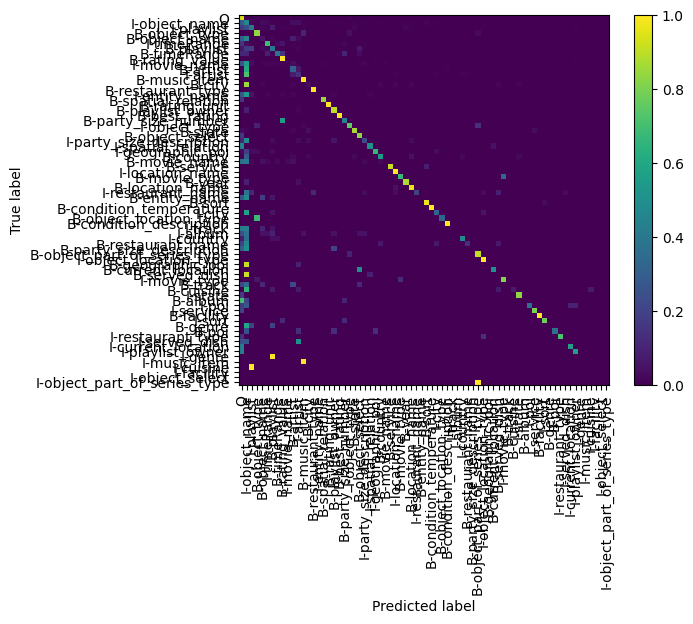

In [97]:
cmd_obj = ConfusionMatrixDisplay(cm, display_labels=labels)
cmd_obj.plot(include_values=False, xticks_rotation='vertical')

In [98]:
sentence = 'Play me Kalinka Malinka'

In [99]:
tokens, pred_tags, unks = tag_sentence(model, device, sentence, tokens_vocab, tags_vocab, TEXT_LOWER)

print(unks)

['kalinka', 'malinka']


In [100]:
print("Pred. Tag\tToken\n")

for token, tag in zip(tokens, pred_tags):
    print(f"{tag}\t\t{token}")

Pred. Tag	Token

O		play
O		me
I-object_name		kalinka
I-object_name		malinka
